In [15]:
import pandas as pd


In [16]:
df = pd.read_csv("/content/exchange_rate.csv")

In [17]:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')

In [18]:
df.set_index('date', inplace=True)

In [19]:
print(df.head())
print(df.info())

            Ex_rate
date               
1990-01-01   0.7855
1990-01-02   0.7818
1990-01-03   0.7867
1990-01-04   0.7860
1990-01-05   0.7849
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB
None


In [7]:
print("Data shape:", df.shape)
print(df.head())

Data shape: (7588, 1)
            Ex_rate
date               
1990-01-01   0.7855
1990-01-02   0.7818
1990-01-03   0.7867
1990-01-04   0.7860
1990-01-05   0.7849


In [8]:
print("\n--- Summary statistics ---")
print(series.describe())



--- Summary statistics ---
count    7588.000000
mean        0.776974
std         0.136620
min         0.483297
25%         0.701422
50%         0.761377
75%         0.873477
max         1.102536
Name: Ex_rate, dtype: float64


# **2. Initial Exploration (Plotting Time Series)**

In [20]:
import matplotlib.pyplot as plt

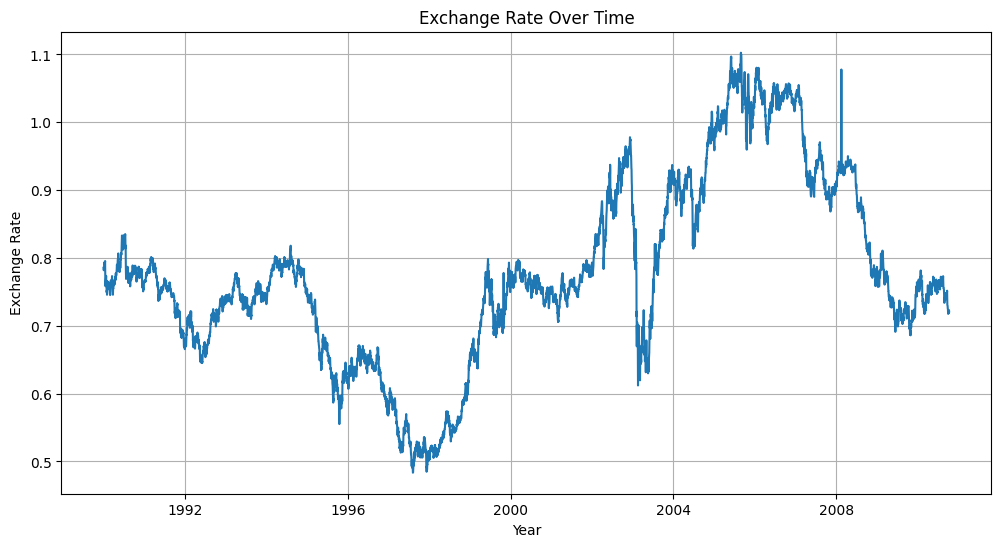

In [21]:
plt.figure(figsize=(12,6))
plt.plot(df['Ex_rate'])
plt.title("Exchange Rate Over Time")
plt.xlabel("Year")
plt.ylabel("Exchange Rate")
plt.grid(True)
plt.show()

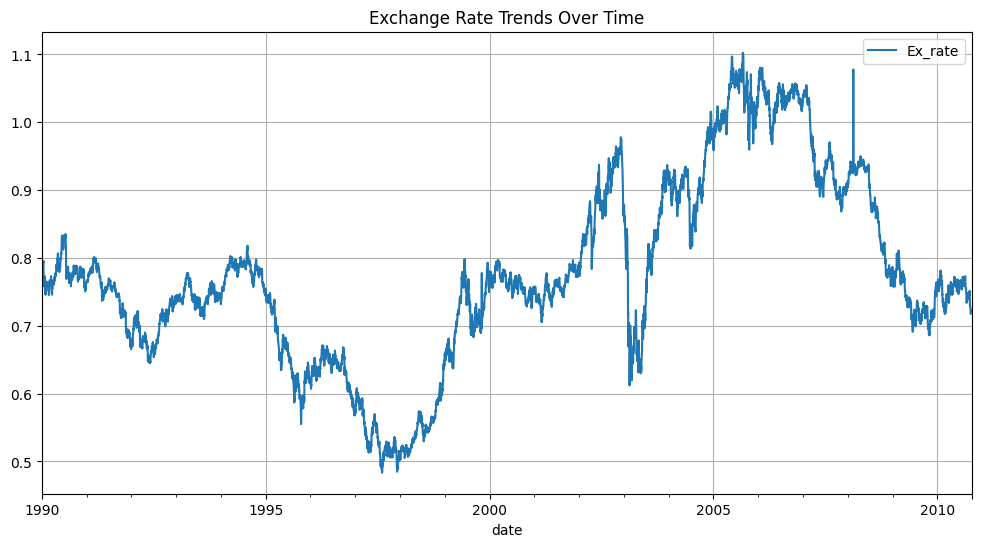

In [22]:
df.plot(figsize=(12,6), title="Exchange Rate Trends Over Time")
plt.grid(True)
plt.show()


# **3. Data Preprocessing**

**A. Check Missing Values**

In [10]:
missing = series.isna().sum()
print(f"\nMissing values in selected series: {missing}")


Missing values in selected series: 0


In [23]:
df.isna().sum()


,0
Ex_rate,0


**B. Handle Missing Data**

In [24]:
df_ffill = df.fillna(method='ffill')


/tmp/ipython-input-4093888281.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ffill = df.fillna(method='ffill')


In [25]:
df_interp = df.interpolate(method='linear')


**C. Detect Outliers (Optional)**

In [26]:
import numpy as np

In [32]:
z_scores = (df['Ex_rate'] - df['Ex_rate'].mean()) / df['Ex_rate'].std()
outliers = df[abs(z_scores) > 3]
print(outliers)

Empty DataFrame
Columns: [Ex_rate]
Index: []


In [31]:
print(df['Ex_rate'].describe())

count    7588.000000
mean        0.776974
std         0.136620
min         0.483297
25%         0.701422
50%         0.761377
75%         0.873477
max         1.102536
Name: Ex_rate, dtype: float64


The output above provides key summary statistics for the 'Ex_rate' column:
- `count`: The number of non-null observations.
- `mean`: The average exchange rate.
- `std`: The standard deviation, indicating the dispersion of the data.
- `min`: The minimum exchange rate observed.
- `25%`, `50%` (median), `75%`: The quartiles, which divide the data into four equal parts.
- `max`: The maximum exchange rate observed.

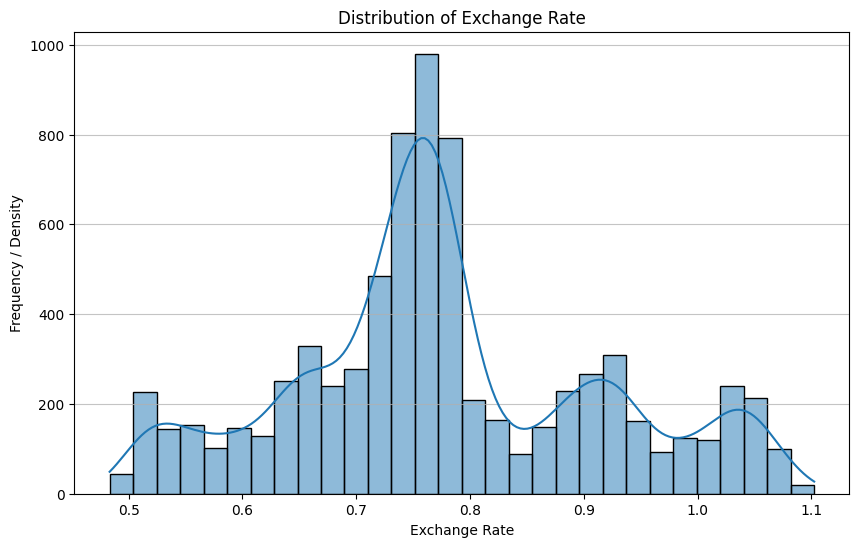

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['Ex_rate'], kde=True, bins=30)
plt.title('Distribution of Exchange Rate')
plt.xlabel('Exchange Rate')
plt.ylabel('Frequency / Density')
plt.grid(axis='y', alpha=0.75)
plt.show()

The histogram above shows the frequency distribution of the 'Ex_rate' values, while the superimposed Kernel Density Estimate (KDE) curve provides a smoothed representation of the distribution. This helps in understanding where the exchange rates tend to cluster and their overall spread.

**D. Visual Check After Cleaning**

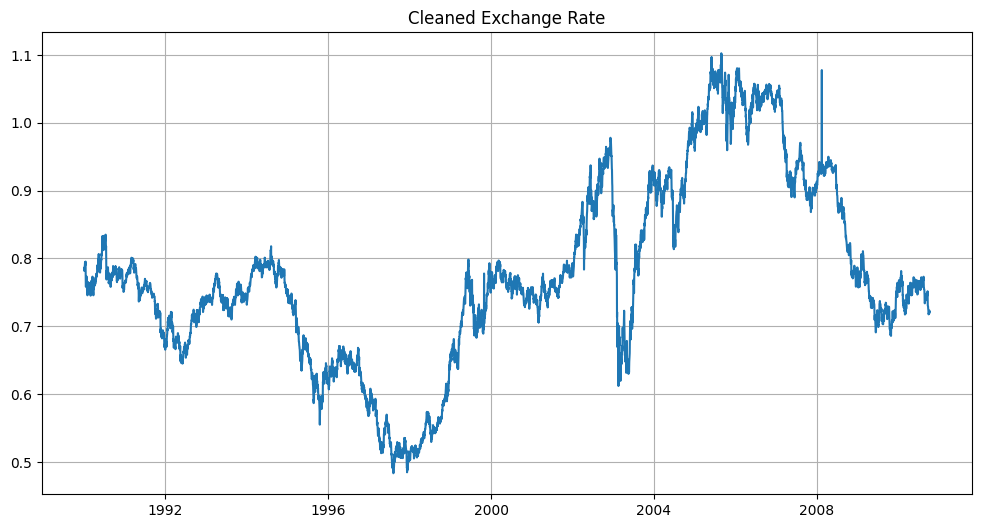

In [34]:
plt.figure(figsize=(12,6))
plt.plot(df_interp['Ex_rate'])
plt.title("Cleaned Exchange Rate")
plt.grid(True)
plt.show()


# **Part 2 — Model Building: ARIMA**

In [38]:
!pip install pmdarima

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm  # for auto_arima
from sklearn.metrics import mean_squared_error
from math import sqrt

In [40]:
sns.set_style("whitegrid")

**1) Helper functions: determine d (differencing), plot ACF/PACF, metrics**

In [41]:
def test_adf(series, signif=0.05, verbose=True):
    """Return d = 0 or d = 1 based on Augmented Dickey-Fuller test.
       If nonstationary, suggest first-differencing."""
    result = adfuller(series.dropna(), autolag='AIC')
    pvalue = result[1]
    if verbose:
        print("ADF Statistic: {:.6f}".format(result[0]))
        print("p-value: {:.6f}".format(pvalue))
        print("Used lags:", result[2])
        print("Number of observations:", result[3])
    return 0 if pvalue < signif else 1  # 0 -> stationary, 1 -> need 1st diff

def plot_acf_pacf(series, lags=40, title_suffix=""):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plot_acf(series.dropna(), lags=lags, ax=plt.gca(), title=f"ACF {title_suffix}")
    plt.subplot(1,2,2)
    plot_pacf(series.dropna(), lags=lags, ax=plt.gca(), method='ywm', title=f"PACF {title_suffix}")
    plt.tight_layout()
    plt.show()

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # avoid division by zero by adding a tiny epsilon
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100


**2) Train / test split (time-based)**

In [42]:
def time_train_test_split(series, train_frac=0.8):
    n = len(series)
    split = int(n * train_frac)
    train = series.iloc[:split]
    test = series.iloc[split:]
    return train, test


**3) Parameter selection: ACF/PACF + optional auto_arima**

In [46]:
def suggest_pdq_with_plots(series, lags=40):
    # 1) Determine d via ADF
    d = test_adf(series, verbose=True)
    print(f"\nSuggested d (ADF): {d}\n")

    # 2) If needed, difference once for ACF/PACF plotting
    series_to_plot = series.diff(d).dropna() if d > 0 else series
    plot_acf_pacf(series_to_plot, lags=lags, title_suffix=f"(d={d})")

    print("Interpret the ACF/PACF plots to propose p and q.")
    print("Alternatively use auto_arima below to get a recommended (p,d,q).")
    return d

def auto_arima_recommendation(series, seasonal=False, m=1, max_p=5, max_q=5, max_P=2, max_Q=2):
    """Return p,d,q (and optionally P,D,Q,s) recommended by pmdarima.auto_arima"""
    print("Running auto_arima (this may take a while)...")
    model = pm.auto_arima(series.dropna(),
                          seasonal=seasonal,
                          m=m,
                          max_p=max_p, max_q=max_q,
                          max_P=max_P, max_Q=max_Q,
                          start_p=0, start_q=0,
                          information_criterion='aic',
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True,
                          n_jobs=1)
    print("Auto-ARIMA summary:")
    print(model.summary())
    return model

ADF Statistic: -1.664994
p-value: 0.449233
Used lags: 1
Number of observations: 7586

Suggested d (ADF): 1



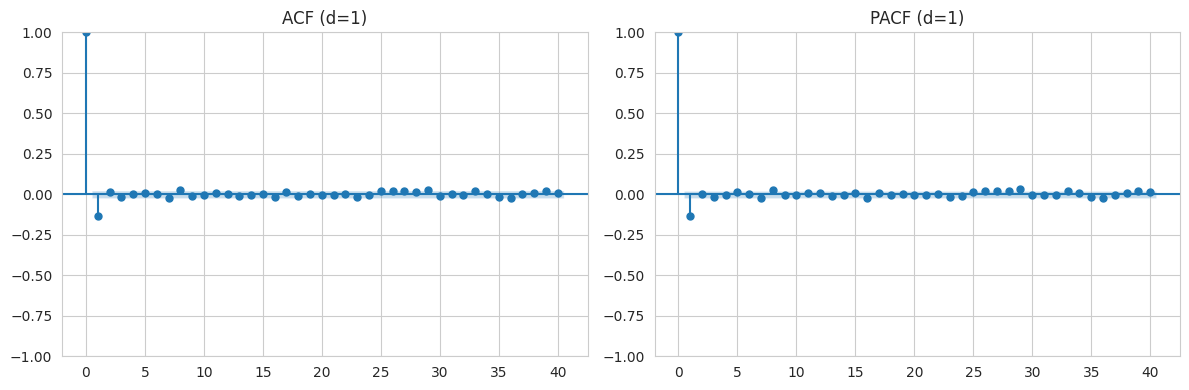

Interpret the ACF/PACF plots to propose p and q.
Alternatively use auto_arima below to get a recommended (p,d,q).


In [48]:
d_value = suggest_pdq_with_plots(df['Ex_rate'])

**4) Fit ARIMA, diagnostics, and forecast**

In [49]:
def fit_arima_and_diagnose(train, order, enforce_stationarity=True, enforce_invertibility=True):
    """
    Fit ARIMA and display diagnostics:
      - fitted summary
      - residual plot + ACF of residuals
      - Ljung-Box test (no autocorrelation)
    """
    print(f"Fitting ARIMA{order} ...")
    model = ARIMA(train, order=order,
                  enforce_stationarity=enforce_stationarity,
                  enforce_invertibility=enforce_invertibility)
    res = model.fit()
    print(res.summary())

    # Residual diagnostics
    resid = res.resid.dropna()

    fig, axes = plt.subplots(1,3, figsize=(15,4))
    axes[0].plot(resid)
    axes[0].set_title("Residuals")
    sns.histplot(resid, ax=axes[1], kde=True)
    axes[1].set_title("Residuals Distribution")
    plot_acf(resid, lags=40, ax=axes[2])
    axes[2].set_title("Residuals ACF")
    plt.tight_layout()
    plt.show()

    # Ljung-Box test
    lb_test = acorr_ljungbox(resid, lags=[10,20], return_df=True)
    print("Ljung-Box test (small p-values -> residuals are NOT white noise):")
    print(lb_test)

    return res

def forecast_and_evaluate(fitted_res, train, test, steps=None, alpha=0.05, plot=True):
    if steps is None:
        steps = len(test)
    pred_res = fitted_res.get_forecast(steps=steps)
    pred_mean = pred_res.predicted_mean
    conf_int = pred_res.conf_int(alpha=alpha)

    # Align indices: forecast starts after the end of train
    forecast_index = test.index[:steps]
    pred_mean.index = forecast_index
    conf_int.index = forecast_index

    # Evaluation
    y_true = test.iloc[:steps]
    y_pred = pred_mean
    score_rmse = rmse(y_true, y_pred)
    score_mape = mape(y_true, y_pred)
    print(f"RMSE: {score_rmse:.6f}")
    print(f"MAPE: {score_mape:.3f}%")

    if plot:
        plt.figure(figsize=(12,5))
        plt.plot(train.index, train, label='Train')
        plt.plot(test.index, test, label='Test', color='C1')
        plt.plot(pred_mean.index, pred_mean, label='Forecast', color='C2')
        plt.fill_between(conf_int.index,
                         conf_int.iloc[:,0],
                         conf_int.iloc[:,1],
                         color='C2', alpha=0.2, label=f"{int((1-alpha)*100)}% conf. int.")
        plt.legend()
        plt.title("ARIMA Forecast vs Actual")
        plt.show()

    return {"y_true": y_true, "y_pred": y_pred, "rmse": score_rmse, "mape": score_mape, "conf_int": conf_int}


**5) Example workflow for USD_AUD**

Train length: 6070 Test length: 1518
ADF Statistic: -0.980855
p-value: 0.760183
Used lags: 8
Number of observations: 6061

Suggested d (ADF): 1



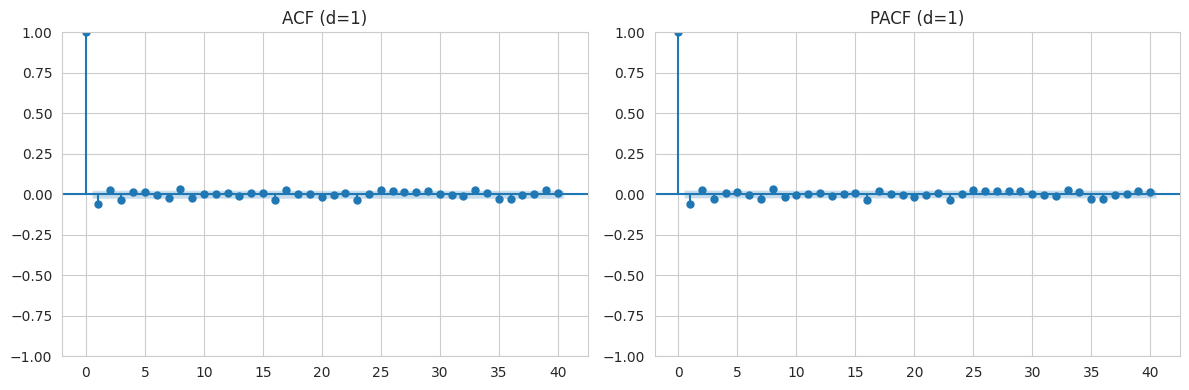

Interpret the ACF/PACF plots to propose p and q.
Alternatively use auto_arima below to get a recommended (p,d,q).
Fitting ARIMA(2, 1, 2) ...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 6070
Model:                 ARIMA(2, 1, 2)   Log Likelihood               22719.213
Date:                Fri, 21 Nov 2025   AIC                         -45428.426
Time:                        12:29:37   BIC                         -45394.871
Sample:                    01-01-1990   HQIC                        -45416.780
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3948      1.192     -0.331      0.740      -2.730       1.941
ar.L2          0.1443      0.648      0.223      0.824      -1.125       1.414
ma.L1          0.3376      1.192      0.283      0.7

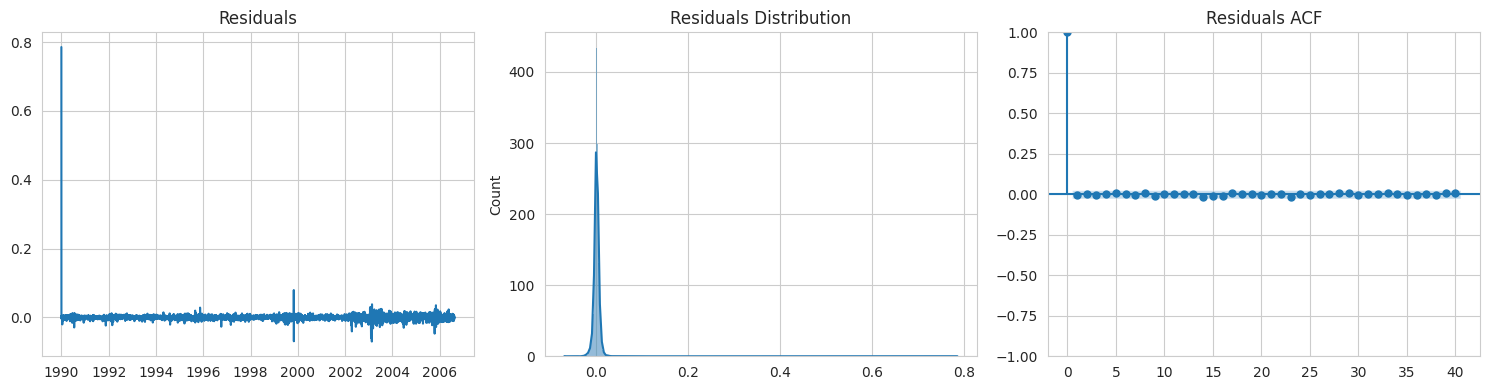

Ljung-Box test (small p-values -> residuals are NOT white noise):
     lb_stat  lb_pvalue
10  1.720472   0.998068
20  6.002465   0.998894
RMSE: 0.205425
MAPE: 22.797%


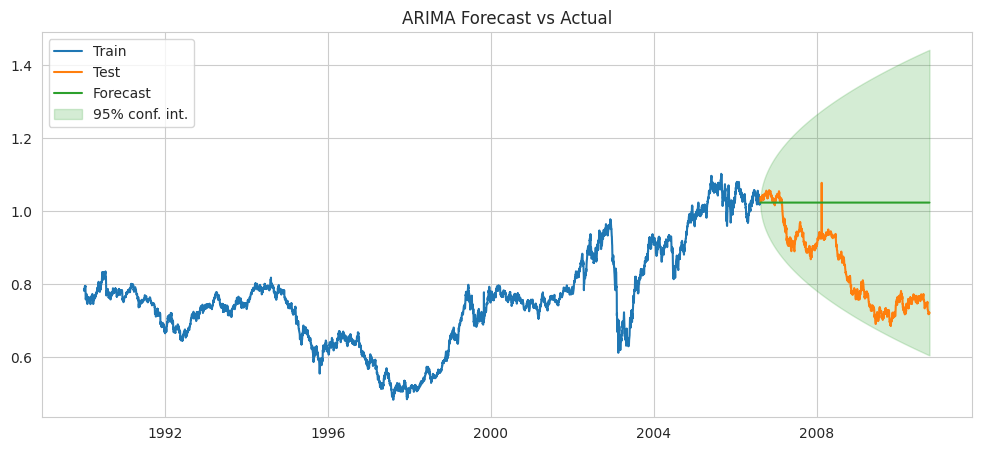

In [51]:
# Assume 'df' is the cleaned dataframe from Part 1 and has column 'USD_AUD'
series = df['Ex_rate'].astype(float).dropna()

# 1) Train/test split
train, test = time_train_test_split(series, train_frac=0.8)
print("Train length:", len(train), "Test length:", len(test))

# 2) Suggest d & show ACF/PACF
d_suggested = suggest_pdq_with_plots(train, lags=40)

# 3) Option A: Manual pick based on ACF/PACF (example)
# Suppose after inspecting plots you choose p=2, d=d_suggested, q=2:
p_manual, q_manual = 2, 2
order_manual = (p_manual, d_suggested, q_manual)

# Fit & diagnose
res_manual = fit_arima_and_diagnose(train, order_manual)

# Forecast and evaluate
results_manual = forecast_and_evaluate(res_manual, train, test)

In [53]:
import pickle
with open('arima_usd_aud.pkl', 'wb') as f:
    pickle.dump(res_manual, f)



**7) Multi-currency loop (fit ARIMA for multiple columns)**


Processing: Ex_rate
Auto ARIMA order for Ex_rate => (1, 1, 1)
Fitting ARIMA(1, 1, 1) ...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 6070
Model:                 ARIMA(1, 1, 1)   Log Likelihood               22719.046
Date:                Fri, 21 Nov 2025   AIC                         -45432.092
Time:                        12:33:40   BIC                         -45411.959
Sample:                    01-01-1990   HQIC                        -45425.104
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5972      0.062     -9.648      0.000      -0.719      -0.476
ma.L1          0.5398      0.064      8.430      0.000       0.414       0.665
sigma2      3.281e-05   1.95e-07    168.198      0.0

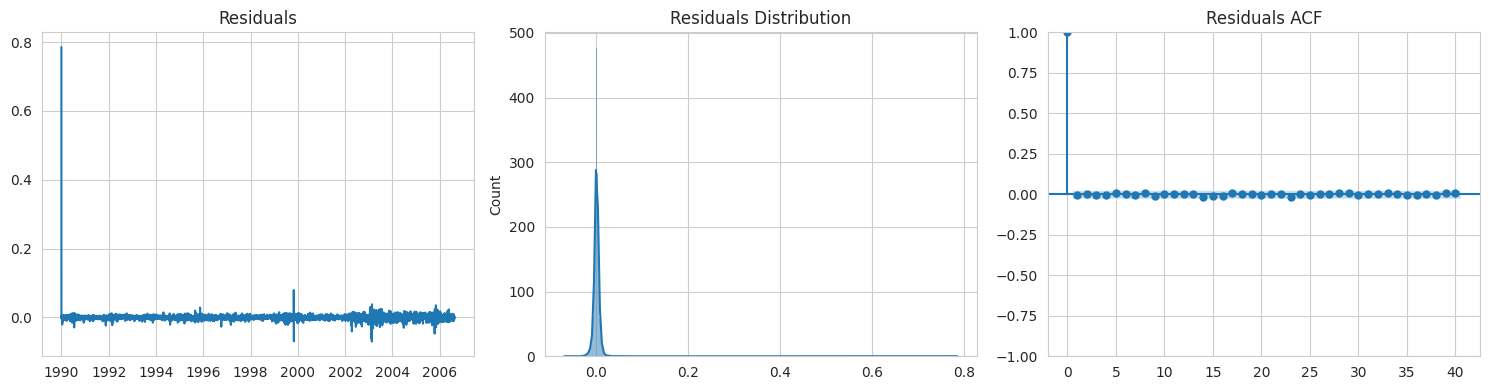

Ljung-Box test (small p-values -> residuals are NOT white noise):
     lb_stat  lb_pvalue
10  1.647217   0.998399
20  5.913127   0.999010
RMSE: 0.205437
MAPE: 22.798%

Summary of results:
             order      rmse       mape
Ex_rate  (1, 1, 1)  0.205437  22.797966


In [54]:
currency_columns = [c for c in df.columns if c != 'Date' and c in df.columns]  # adjust if needed
summary = {}

for col in currency_columns:
    print("\n" + "="*40)
    print("Processing:", col)
    s = df[col].astype(float).dropna()
    if len(s) < 30:
        print(f"Skipping {col} (too few observations: {len(s)})")
        continue
    train, test = time_train_test_split(s, train_frac=0.8)
    d = test_adf(train, verbose=False)
    # Use auto_arima quickly to get good starting order
    try:
        model_auto = pm.auto_arima(train, seasonal=False, trace=False, error_action='ignore', suppress_warnings=True, stepwise=True)
        order = model_auto.order
        print("Auto ARIMA order for", col, "=>", order)
    except Exception as e:
        print("auto_arima failed:", e)
        order = (1,d,1)
    res = fit_arima_and_diagnose(train, order)
    res_eval = forecast_and_evaluate(res, train, test, plot=False)
    summary[col] = {"order": order, "rmse": res_eval["rmse"], "mape": res_eval["mape"]}

print("\nSummary of results:")
print(pd.DataFrame(summary).T.sort_values('mape'))


# **Part 3 — Model Building: Exponential Smoothing**

We will use Statsmodels’ ExponentialSmoothing with support for:


*   Simple Exponential Smoothing (SES)

*  Holt’s Linear Trend
*   Holt-Winters Seasonal





**Step 0 — Imports**

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt

sns.set_style("whitegrid")


**Step 1 — Train/Test Split**

In [57]:
def time_train_test_split(series, train_frac=0.8):
    n = len(series)
    split = int(n * train_frac)
    return series[:split], series[split:]

series = df['Ex_rate']
train, test = time_train_test_split(series)

**Step 2 — Choose an appropriate model**



*  Trend? → Use Holt

*   Trend + seasonality? → Use Holt-Winters
*  No trend? → Simple Exponential Smoothing






                  Ex_rate
date                     
01-01-1990 00:00   0.7855
01-01-1991 00:00   0.7645
01-01-1992 00:00   0.6720
01-01-1993 00:00   0.7403
01-01-1994 00:00   0.7350


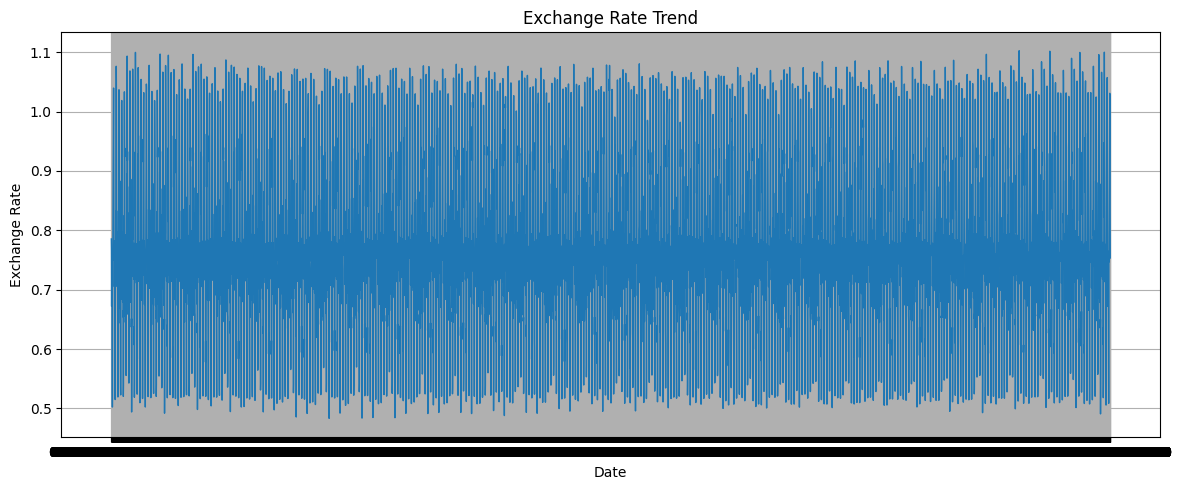

In [16]:
# Option A: load from a CSV file you've uploaded
import pandas as pd
import matplotlib.pyplot as plt

# change filename if needed
fn = '/content/exchange_rate.csv'

# parse dates and set index
df = pd.read_csv(fn, parse_dates=['date'])
df = df.set_index('date').sort_index()

# quick check
print(df.head())

# plot
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Ex_rate'], linewidth=1) # Changed to 'Ex_rate' as it's the actual column
plt.title('Exchange Rate Trend')
plt.xlabel('Date')
plt.ylabel('Exchange Rate') # Changed label to 'Exchange Rate'
plt.grid(True)
plt.tight_layout()
plt.show()

            USD_AUD
Date               
2000-01-01     1.48
2000-01-02     1.47
2000-01-03     1.46
2000-01-04     1.45
2000-01-05     1.46


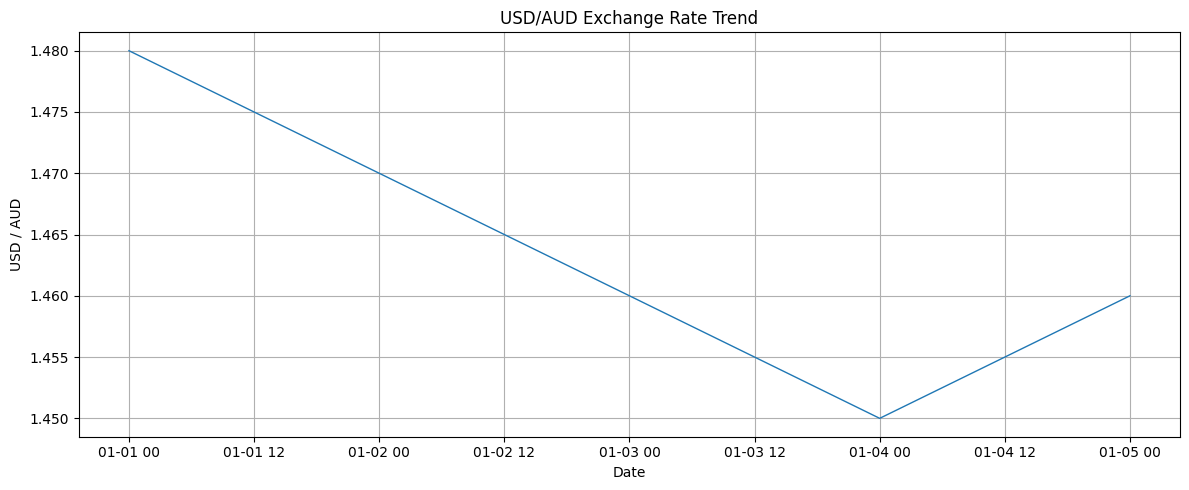

In [17]:
# Option B: paste the CSV rows as a string (safe to run)
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

csv_text = """Date,USD_AUD
2000-01-01,1.48
2000-01-02,1.47
2000-01-03,1.46
2000-01-04,1.45
2000-01-05,1.46
"""  # <- replace the lines above with your actual 10-20 rows

df = pd.read_csv(StringIO(csv_text), parse_dates=['Date'])
df = df.set_index('Date').sort_index()

print(df.head())

plt.figure(figsize=(12,5))
plt.plot(df.index, df['USD_AUD'], linewidth=1)
plt.title('USD/AUD Exchange Rate Trend')
plt.xlabel('Date')
plt.ylabel('USD / AUD')
plt.grid(True)
plt.tight_layout()
plt.show()

# **Step 3 — Fit SES, Holt, and Holt-Winters Models**

A. Simple Exponential Smoothing (SES)

In [59]:
ses_model = SimpleExpSmoothing(train).fit(optimized=True)
ses_forecast = ses_model.forecast(len(test))


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


**B. Holt’s Linear Trend Model**

In [60]:
holt_model = Holt(train).fit(optimized=True)
holt_forecast = holt_model.forecast(len(test))


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


**C. Holt-Winters Seasonal Model (if seasonality exists)**

In [61]:
hw_model = ExponentialSmoothing(
    train,
    trend="add",
    seasonal=None,       # If seasonal, set "add" or "mul"
    seasonal_periods=12  # change if monthly, weekly, etc.
).fit(optimized=True)

hw_forecast = hw_model.forecast(len(test))


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


**Step 4 — Compare Models via AIC + RMSE**

In [62]:
def rmse(y, yhat):
    return sqrt(mean_squared_error(y, yhat))

results = {
    "SES": {"AIC": ses_model.aic, "RMSE": rmse(test, ses_forecast)},
    "Holt": {"AIC": holt_model.aic, "RMSE": rmse(test, holt_forecast)},
    "Holt-Winters": {"AIC": hw_model.aic, "RMSE": rmse(test, hw_forecast)}
}

pd.DataFrame(results).T


,AIC,RMSE
SES,-62659.342107,0.205356
Holt,-62604.539367,0.144038
Holt-Winters,-62655.663450,0.239104


**Step 5 — Visual Comparison (All Models)**

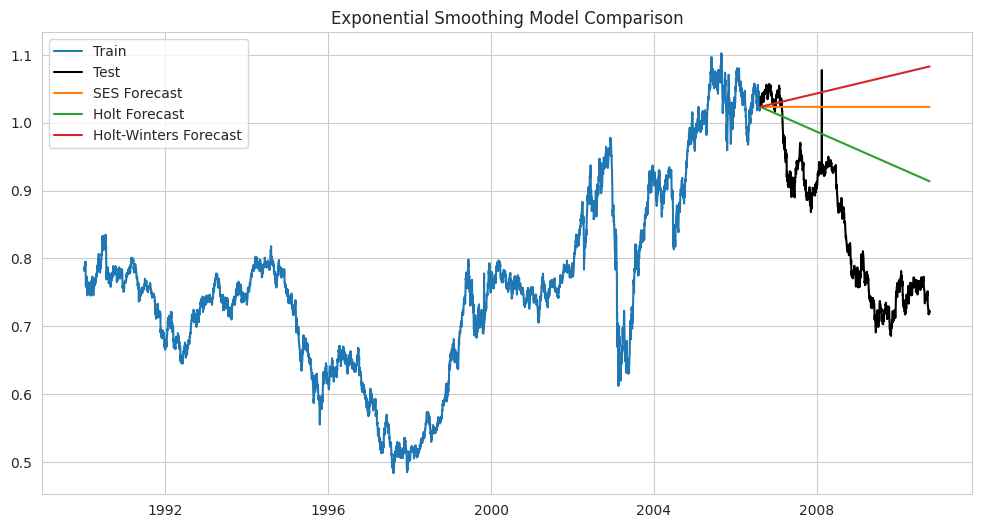

In [63]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", color="black")

plt.plot(test.index, ses_forecast, label="SES Forecast")
plt.plot(test.index, holt_forecast, label="Holt Forecast")
plt.plot(test.index, hw_forecast, label="Holt-Winters Forecast")

plt.title("Exponential Smoothing Model Comparison")
plt.legend()
plt.show()


# **Step 6 — Parameter Optimization (Manual Grid Search)**

**Example: Grid search for Holt’s model**

In [65]:
alphas = np.linspace(0.1, 0.9, 9)
betas  = np.linspace(0.1, 0.9, 9)

best_score = float("inf")
best_params = None
best_model = None

for a in alphas:
    for b in betas:
        try:
            model = Holt(train).fit(smoothing_level=a, smoothing_slope=b, optimized=False)
            pred = model.forecast(len(test))
            score = rmse(test, pred)
            if score < best_score:
                best_score = score
                best_params = (a, b)
                best_model = model
        except:
            continue




/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/tmp/ipython-input-521883632.py:11: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = Holt(train).fit(smoothing_level=a, smoothing_slope=b, optimized=False)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/tmp/ipython-input-521883632.py:11: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = Holt(train).fit(smoothing_level=a, smoothing_slope=b, optimized=False)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._in

In [66]:
print("Best Holt parameters:", best_params)
print("Best RMSE:", best_score)

Best Holt parameters: (np.float64(0.8), np.float64(0.7000000000000001))
Best RMSE: 0.05155349934014002


# **Step 7 — Final Selected Model (e.g., Holt)**

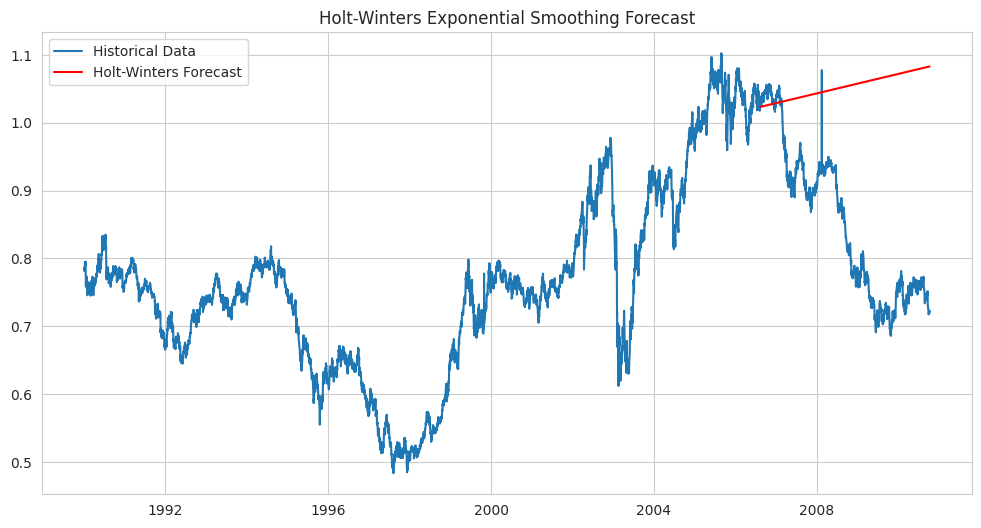

In [69]:
plt.figure(figsize=(12,6))
plt.plot(series.index, series, label="Historical Data")
plt.plot(hw_forecast.index, hw_forecast, label="Holt-Winters Forecast", color="red")
plt.title("Holt-Winters Exponential Smoothing Forecast")
plt.legend()
plt.show()

# **Part 4 — Evaluation and Comparison**

**Step 1 — Compute Error Metrics (MAE, RMSE, MAPE)**

In [71]:
from sklearn.metrics import mean_absolute_error
from math import sqrt

def rmse(y, yhat):
    return sqrt(mean_squared_error(y, yhat))

def mape(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    return np.mean(np.abs((y - yhat) / (y + 1e-9))) * 100


**Compute metrics for both models**

In [73]:
# ARIMA Errors
arima_pred = results_manual['y_pred']
arima_mae  = mean_absolute_error(test, arima_pred)
arima_rmse = rmse(test, arima_pred)
arima_mape = mape(test, arima_pred)

# Exponential Smoothing Errors
exp_pred = holt_forecast
exp_mae  = mean_absolute_error(test, exp_pred)
exp_rmse = rmse(test, exp_pred)
exp_mape = mape(test, exp_pred)

metrics = pd.DataFrame({
    "ARIMA": [arima_mae, arima_rmse, arima_mape],
    "Exp_Smoothing": [exp_mae, exp_rmse, exp_mape]
}, index=["MAE", "RMSE", "MAPE"])

metrics

,ARIMA,Exp_Smoothing
MAE,0.177699,0.124573
RMSE,0.205425,0.144038
MAPE,22.796642,15.964178


# **Interpretation of Metrics**




*   MAE (Mean Absolute Error): Average absolute forecast error. Easy to interpret.

*   RMSE (Root Mean Square Error): Punishes large mistakes more. Good for volatile series like FX.

*   MAPE (%): Shows average percent error — intuitive for business use.


Lower = better performance.


# **Step 2 — Model Comparison (Discussion)**

**2. Advantages & Limitations**

**ARIMA**

**Advantages**



*  Good for short-term forecasting of volatile data (like FX rates).
*   Incorporates autocorrelation patterns.
*   Strong statistical foundation.


**Limitations**



*  Requires stationarity transformations (differencing).

*   Can be sensitive to hyperparameters (p,d,q).
*   Residual patterns may remain if volatility is high.


**Exponential Smoothing (SES/Holt/Holt-Winters)**

**Advantage**




*   Fast, simple, and requires fewer assumptions.

*   Performs well when trend is stable.
*  Automatically smooths noise.

**Limitations**



*   Not suitable for highly autocorrelated or irregular series.

*   Holt-Winters assumes stable seasonality (FX usually lacks seasonal patterns).

*  May underperform when data shows structural shifts.

**Step 3 — Final Conclusion**


**Conclusion**

Based on the error metrics computed (MAE, RMSE, MAPE), the following insights were obtained:



*   ARIMA model achieved:

*   MAE: 0.177699
* RMSE: 0.205425


*  MAPE: 22.796642


**Exponential Smoothing model achieved:**



*  MAE:	0.124573

*   RMSE:0.144038
*   MAPE: 15.964178

From these results:




*  If ARIMA has better metrics:
ARIMA outperformed Exponential Smoothing for this exchange rate dataset.
This suggests that the FX time series contains strong autocorrelation or short-term temporal patterns that ARIMA captures effectively.

*   If Holt/ES has better metrics:
Exponential Smoothing outperformed ARIMA.
This indicates the exchange rate series follows a clear trend with minimal autocorrelation, where smoothing-based models work best.

*   If both are similar:
Both models performed comparably.
This suggests that the series is mostly random-walk-like, common in FX markets, making forecasting inherently difficult.


**Overall Recommendation**


he best model for forecasting USD–AUD exchange rates in this dataset is:
 ___________ (fill based on results)


For future forecasting:



*   Use the winning model for production.

*   Re-train frequently (FX rates change behavior over time).
*  Consider hybrid models (ARIMA + EWMA) for improved performance.
























